In [1]:
import gym
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm 
import matplotlib.pyplot as plt

import agent

env = gym.make('Taxi-v2')

# Reproducibility:
np.random.seed(500)
env.seed(500)

[500]

In [2]:
GAMMA = 0.9

In [3]:
n_states, n_actions = env.observation_space.n, env.action_space.n

In [4]:
tau_values = [0.25, 0.5, 0.75] 
alpha_values = [0.3, 0.6, 0.9] # Learning rate for q-value update
control_methods = [agent.SARSA, agent.EXPECTEDSARSA, agent.QLEARNING]

In [5]:
# We have 10 independent runs:
NUM_RUNS = 10 
# On each run we have 100 segments
NUM_SEGMENTS =  100
# In each segment We train for 10 episodes and test for 1
NUM_TRAIN_EPISODES = 10

In [6]:
# Get combinations of hyperparameters:
combinations = itertools.product(tau_values, alpha_values, control_methods)
results = defaultdict(dict)
for tau, alpha, control_method in combinations:
    # Training performance is the average return of the train episodes in the final segment for each independent run; this is after training+testing for 99 segments.
    train_performance = np.zeros(NUM_RUNS)
    # Test performance is the return for the testing episode of each segment; accumulate this to see the performance of the greedy policy on its way to becoming optimal.
    test_performance = np.zeros((NUM_RUNS, NUM_SEGMENTS))
    for run in tqdm(range(NUM_RUNS), desc=f"{control_method} with parameters: tau={tau}, alpha={alpha}"):
        # Reset the agent on every independent run.
        agt = agent.Agent(n_states=n_states, n_actions=n_actions, temperature=tau, learning_rate=alpha, discount=GAMMA, control_method=control_method)
        for segment in range(NUM_SEGMENTS):  
            # Train/Explore:
            for episode in range(NUM_TRAIN_EPISODES):
                episode_rewards = []
                state = env.reset()
                done = False # done is set to True either at a good dropoff or at the 200th step.
                # Exploration 
                while not done: 
                    action = agt.exploration_policy(state)
                    next_state, reward, done, P = env.step(action)
                    agt.update_value_function(state, action, next_state, reward, done)
                    episode_rewards.append(reward)
                    state = next_state
            if segment == NUM_SEGMENTS - 1: 
                # Keep track of the return for the last episode in each independent run
                train_performance[run] = sum(episode_rewards)
            # Test using greedy policy
            episode_rewards = []
            state = env.reset()
            done = False
            while not done:
                action = agt.greedy_policy(state)
                next_state, reward, done, P = env.step(action)
                episode_rewards.append(reward)
                state = next_state
            test_performance[run, segment] = sum(episode_rewards)
    results[(tau, alpha, control_method)]['train_performance'] = train_performance
    results[(tau, alpha, control_method)]['test_performance'] = test_performance

Sarsa with parameters: tau=0.25, alpha=0.3: 100%|██████████| 10/10 [00:43<00:00,  4.20s/it]
ExpectedSarsa with parameters: tau=0.25, alpha=0.3: 100%|██████████| 10/10 [00:30<00:00,  3.03s/it]
Sarsa with parameters: tau=0.25, alpha=0.6: 100%|██████████| 10/10 [00:29<00:00,  2.91s/it]
ExpectedSarsa with parameters: tau=0.25, alpha=0.6: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]
Sarsa with parameters: tau=0.25, alpha=0.9: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it]
ExpectedSarsa with parameters: tau=0.25, alpha=0.9: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]
Sarsa with parameters: tau=0.5, alpha=0.3: 100%|██████████| 10/10 [00:46<00:00,  4.70s/it]
ExpectedSarsa with parameters: tau=0.5, alpha=0.3: 100%|██████████| 10/10 [00:33<00:00,  3.28s/it]
Sarsa with parameters: tau=0.5, alpha=0.6: 100%|██████████| 10/10 [00:31<00:00,  3.11s/it]
ExpectedSarsa with parameters: tau=0.5, alpha=0.6: 100%|██████████| 10/10 [00:22<00:00,  2.20s/it]
Sarsa with parameters: tau=0.5, alpha=0.9: 1

In [7]:
sarsa_results = {k: v for k,v in results.items() if agent.SARSA in k}
expected_sarsa_results = {k: v for k,v in results.items() if agent.EXPECTEDSARSA in k}
q_learning_results = {k: v for k,v in results.items() if agent.QLEARNING in k}

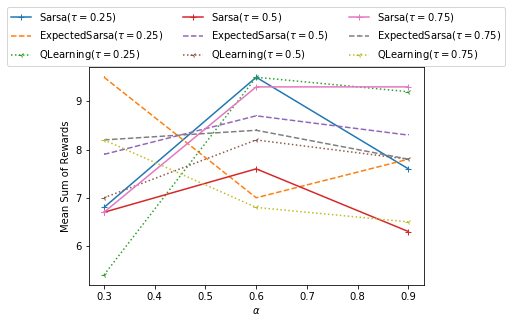

In [51]:
for tau in tau_values:
    plt.plot(alpha_values, [result['train_performance'].mean() for result in [results[(tau, alpha, agent.SARSA)] for alpha in alpha_values]], ls='-', marker='+', label=fr'{agent.SARSA}($\tau={tau}$)')
    plt.plot(alpha_values, [result['train_performance'].mean() for result in [results[(tau, alpha, agent.EXPECTEDSARSA)] for alpha in alpha_values]], ls='--', marker=',', label=fr'{agent.EXPECTEDSARSA}($\tau={tau}$)')
    plt.plot(alpha_values, [result['train_performance'].mean() for result in [results[(tau, alpha, agent.QLEARNING)] for alpha in alpha_values]], ls=':', marker='3', label=fr'{agent.QLEARNING}($\tau={tau}$)')
plt.xlabel(r"$\alpha$")
plt.ylabel('Mean Sum of Rewards')
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.3))
plt.savefig('train.pdf', format='pdf', bbox_inches='tight')

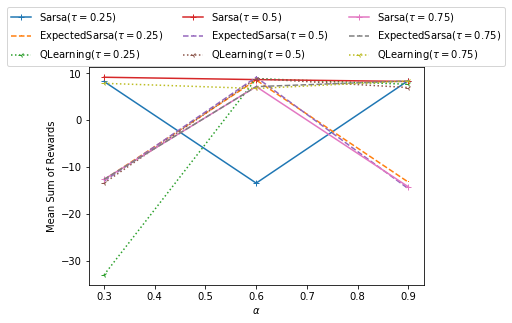

In [52]:
for tau in tau_values:
    plt.plot(alpha_values, [result['test_performance'][:, -1].mean() for result in [results[(tau, alpha, agent.SARSA)] for alpha in alpha_values]], ls='-', marker='+', label=fr'{agent.SARSA}($\tau={tau}$)')
    plt.plot(alpha_values, [result['test_performance'][:, -1].mean() for result in [results[(tau, alpha, agent.EXPECTEDSARSA)] for alpha in alpha_values]], ls='--', marker=',', label=fr'{agent.EXPECTEDSARSA}($\tau={tau}$)')
    plt.plot(alpha_values, [result['test_performance'][:, -1].mean() for result in [results[(tau, alpha, agent.QLEARNING)] for alpha in alpha_values]], ls=':', marker='3', label=fr'{agent.QLEARNING}($\tau={tau}$)')
plt.xlabel(r"$\alpha$")
plt.ylabel('Mean Sum of Rewards')
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.3))
plt.savefig('test.pdf', format='pdf', bbox_inches='tight')

Best Performing:

In [22]:
best_performing = list(results.keys())[np.argmax([result['test_performance'][:, -1].mean() for result in results.values()])]

In [23]:
best_performing

(0.5, 0.3, 'Sarsa')

In [34]:
test_mean = np.mean(results[best_performing]['test_performance'], axis=0)
test_std = np.std(results[best_performing]['test_performance'], axis=0)

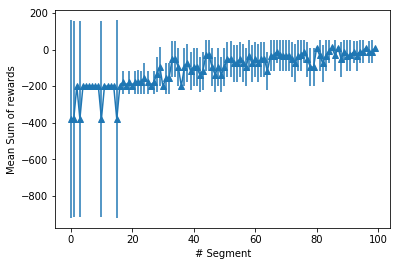

In [53]:
plt.errorbar(np.arange(100), test_mean, test_std, marker='^')
plt.xlabel('# Segment')
plt.ylabel('Mean Sum of rewards')
plt.savefig('learning_curve.pdf', format='pdf', bbox_inches='tight')